### Librerias y Funciones

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

#### Librerias y Funciones

In [0]:
from IPython.display import display

# mute warnings
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.sql import Window
from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import mlflow
import plotly.express as px
pd.set_option('display.max_rows', 520)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_theme(style="ticks")
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn import metrics


pd.set_option('display.float_format', lambda x: '%.5f' % x)

from IPython.display import display
import pyspark.sql.functions as F
import pandas as pd
from pyspark.sql import Window
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
import seaborn as sns

#### Carga de Fuentes

In [0]:
tb_pedidos_clientes = spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")

#### Analisis Exploratorio Inicial

In [0]:
tb_pedidos_clientes.limit(5).display()

cliente_id,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas
C089085,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R003,TIENDA,BAJA,1,LMV,2023-05-17T00:00:00Z,VENDEDOR,161.55,4,3.21
C073952,GT,NORTE,GT-NOR-A010,GT-NOR-A010-R009,TIENDA,BAJA,1,LMI,2023-10-07T00:00:00Z,VENDEDOR,137.36,2,7.42
C101443,GT,METROPOLITANA,GT-MET-A002,GT-MET-A002-R010,TIENDA,ALTA,1,LMV,2023-01-05T00:00:00Z,DIGITAL,80.77,8,13.53
C055939,PE,SELVA,PE-SEL-A002,PE-SEL-A002-R013,MINIMARKET,BAJA,1,LMV,2024-01-13T00:00:00Z,DIGITAL,92.68,2,16.67
C088826,EC,SIERRA,EC-SIE-A002,EC-SIE-A002-R005,TIENDA,MEDIA,2,L,2023-10-01T00:00:00Z,DIGITAL,125.18,3,16.37


In [0]:
tb_pedidos_clientes.printSchema()

root
 |-- cliente_id: string (nullable = true)
 |-- pais_cd: string (nullable = true)
 |-- region_comercial_txt: string (nullable = true)
 |-- agencia_id: string (nullable = true)
 |-- ruta_id: string (nullable = true)
 |-- tipo_cliente_cd: string (nullable = true)
 |-- madurez_digital_cd: string (nullable = true)
 |-- estrellas_txt: string (nullable = true)
 |-- frecuencia_visitas_cd: string (nullable = true)
 |-- fecha_pedido_dt: timestamp (nullable = true)
 |-- canal_pedido_cd: string (nullable = true)
 |-- facturacion_usd_val: double (nullable = true)
 |-- materiales_distintos_val: long (nullable = true)
 |-- cajas_fisicas: double (nullable = true)



In [0]:
tb_pedidos_clientes_pd = tb_pedidos_clientes.toPandas()

In [0]:
df_null = null_function(tb_pedidos_clientes_pd)
df_null.sort_values("per_null", ascending=False).head(10)

,variable,num_datos,num_null,per_null
0,cliente_id,1250000,0,0.00000
1,pais_cd,1250000,0,0.00000
2,region_comercial_txt,1250000,0,0.00000
3,agencia_id,1250000,0,0.00000
4,ruta_id,1250000,0,0.00000
5,tipo_cliente_cd,1250000,0,0.00000
6,madurez_digital_cd,1250000,0,0.00000
7,estrellas_txt,1250000,0,0.00000
8,frecuencia_visitas_cd,1250000,0,0.00000
9,fecha_pedido_dt,1250000,0,0.00000


In [0]:
num_cols = df_pedidos_clientes.select_dtypes("number").columns.tolist()

numeric_eda(df_pedidos_clientes, num_cols).round(3)

,variable,num_datos,num_null,per_null,mean,std,min,per_1,per_5,per_25,median,per_75,per_95,per_99,max
0,facturacion_usd_val,1250000,0,0.00000,120.32300,49.35400,0.00000,10.86000,38.05000,86.36000,120.08000,153.76000,202.30100,236.44000,366.38000
1,materiales_distintos_val,1250000,0,0.00000,7.50100,4.03200,1.00000,1.00000,1.00000,4.00000,8.00000,11.00000,14.00000,14.00000,14.00000
2,cajas_fisicas,1250000,0,0.00000,12.02800,4.93400,0.00000,1.07000,3.81000,8.63000,12.00000,15.37000,20.24000,23.64000,38.15000


In [0]:
cat_cols = df_pedidos_clientes.select_dtypes("object").columns.tolist()

category_eda(df_pedidos_clientes, cat_cols).round(3)

,variable,num_category,mode,mode_count,num_datos,count_datos,mode_per_total,mode_per_sin_null,category
0,cliente_id,149960,C002719,25,1250000,1250000,0.00000,0.00000,"[C089085, C073952, C101443, C055939, C088826, ..."
1,pais_cd,4,EC,313846,1250000,1250000,0.25100,0.25100,"[SV, GT, PE, EC]"
2,region_comercial_txt,11,OCCIDENTE,278319,1250000,1250000,0.22300,0.22300,"[ORIENTE, NORTE, METROPOLITANA, SELVA, SIERRA,..."
3,agencia_id,116,EC-AMA-A004,31767,1250000,1250000,0.02500,0.02500,"[SV-ORI-A002, GT-NOR-A010, GT-MET-A002, PE-SEL..."
4,ruta_id,1598,EC-AMA-A002-R003,1753,1250000,1250000,0.00100,0.00100,"[SV-ORI-A002-R003, GT-NOR-A010-R009, GT-MET-A0..."
5,tipo_cliente_cd,3,TIENDA,750088,1250000,1250000,0.60000,0.60000,"[TIENDA, MINIMARKET, MAYORISTA]"
6,madurez_digital_cd,3,BAJA,625987,1250000,1250000,0.50100,0.50100,"[BAJA, ALTA, MEDIA]"
7,estrellas_txt,3,1,543981,1250000,1250000,0.43500,0.43500,"[1, 2, 3]"
8,frecuencia_visitas_cd,4,LM,314068,1250000,1250000,0.25100,0.25100,"[LMV, LMI, L, LM]"
9,canal_pedido_cd,3,DIGITAL,599238,1250000,1250000,0.47900,0.47900,"[VENDEDOR, DIGITAL, TELEFONO]"


#### Analisis de Canales

In [0]:
df_pedidos_clientes = tb_pedidos_clientes.toPandas()

Text(0.5, 1.0, 'Distribución de pedidos por canal')

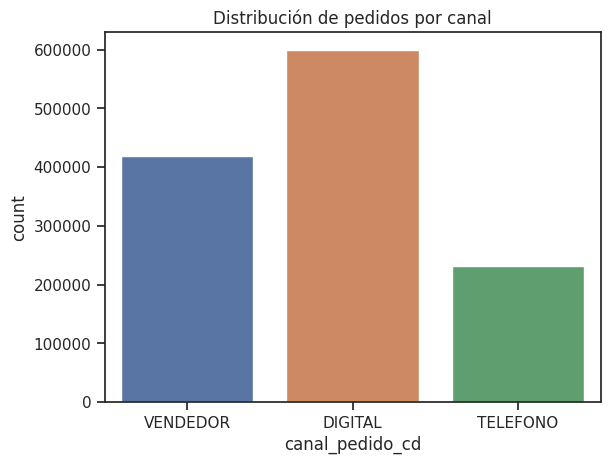

In [0]:
sns.countplot(x="canal_pedido_cd", data=df_pedidos_clientes)
plt.title("Distribución de pedidos por canal")

Text(0.5, 1.0, 'Distribucion de pedidos por canal')

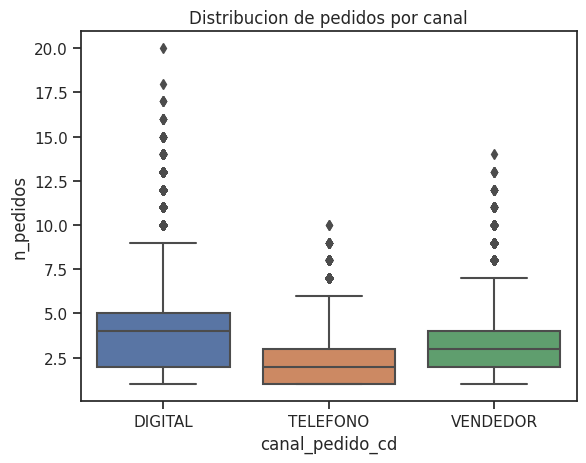

In [0]:
frecuencia = df.groupby(['cliente_id', 'canal_pedido_cd']).size().reset_index(name='n_pedidos')
sns.boxplot(data=frecuencia, x='canal_pedido_cd', y='n_pedidos')
plt.title("Distribucion de pedidos por canal")


Text(0.5, 1.0, 'Distribución de pedidos por canal y pais')

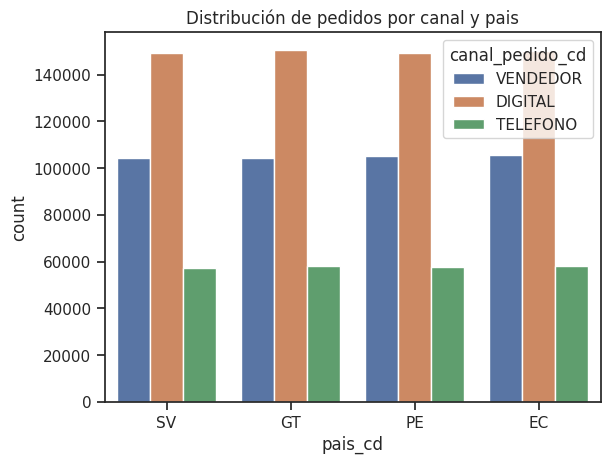

In [0]:
sns.countplot(data=df_pedidos_clientes, x="pais_cd", hue="canal_pedido_cd")
plt.title("Distribución de pedidos por canal y pais")

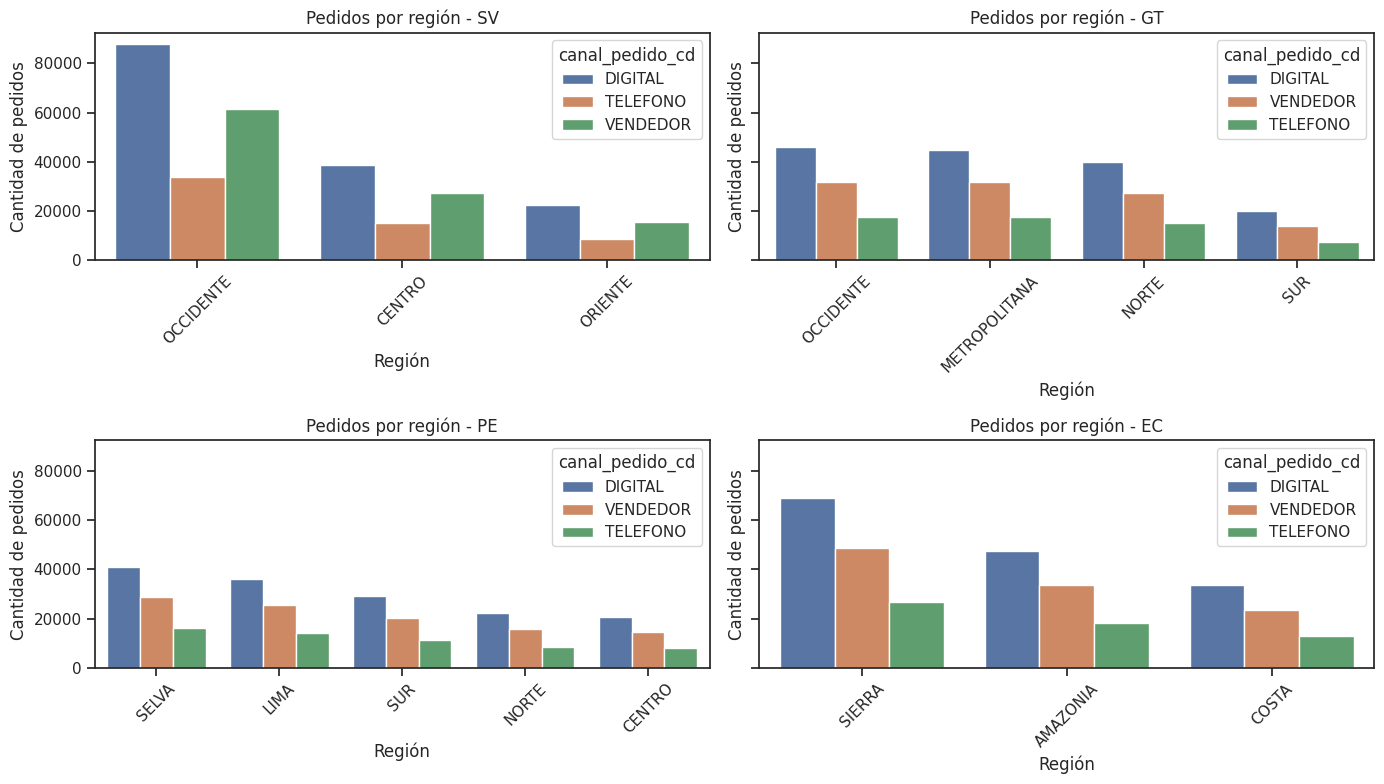

In [0]:
# Crear figura con un subplot por país
paises = df_pedidos_clientes['pais_cd'].unique()
n_paises = len(paises)

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True); axes = axes.flatten()

# Iterar por país y graficar
for ax, pais in zip(axes, paises):
    subset = df[df['pais_cd'] == pais]
    sns.countplot(data=subset, x='region_comercial_txt', hue="canal_pedido_cd", ax=ax, order=subset['region_comercial_txt'].value_counts().index)
    ax.set_title(f'Pedidos por región - {pais}')
    ax.set_xlabel('Región')
    ax.set_ylabel('Cantidad de pedidos')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [0]:
df_pedidos_clientes.columns

Index(['cliente_id', 'pais_cd', 'region_comercial_txt', 'agencia_id', 'ruta_id', 'tipo_cliente_cd', 'madurez_digital_cd', 'estrellas_txt', 'frecuencia_visitas_cd', 'fecha_pedido_dt', 'canal_pedido_cd', 'facturacion_usd_val', 'materiales_distintos_val', 'cajas_fisicas', 'mes_anio'], dtype='object')

Text(0.5, 1.0, 'pedidos por tipo de cliente y por canal')

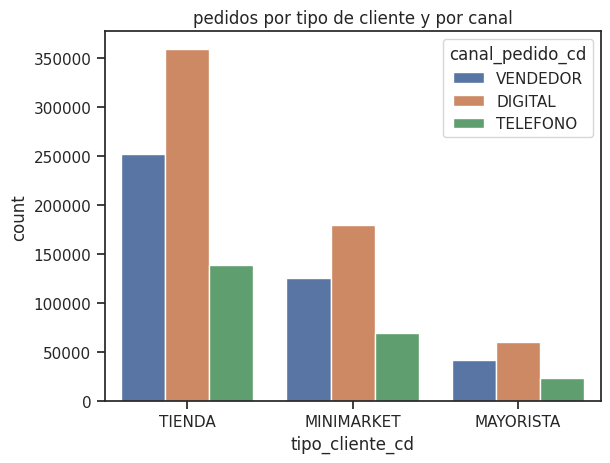

In [0]:
sns.countplot(data=df_pedidos_clientes, x="tipo_cliente_cd", hue="canal_pedido_cd")
plt.title("pedidos por tipo de cliente y por canal")

Text(0.5, 1.0, 'pedidos por madurez_digital_cd y por canal')

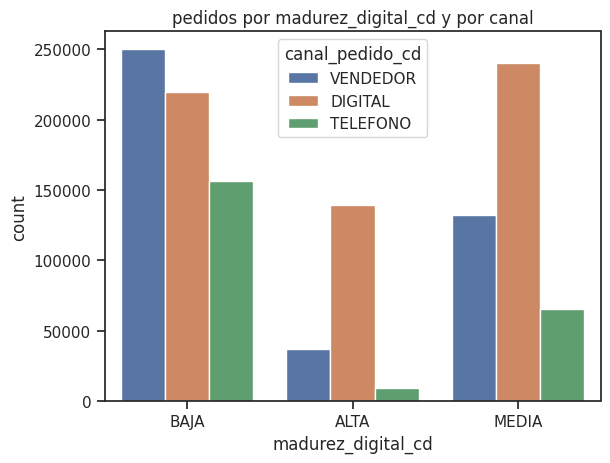

In [0]:
sns.countplot(data=df_pedidos_clientes, x="madurez_digital_cd", hue="canal_pedido_cd")
plt.title("pedidos por madurez_digital_cd y por canal")

Text(0.5, 1.0, 'facturacion_usd_val y por canal')

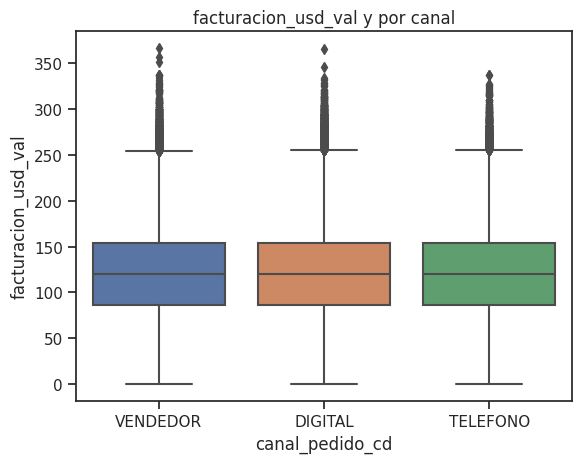

In [0]:
sns.boxplot(data=df_pedidos_clientes, x="canal_pedido_cd", y="facturacion_usd_val")
plt.title("facturacion_usd_val y por canal")

Text(0.5, 1.0, 'materiales_distintos_val por canal')

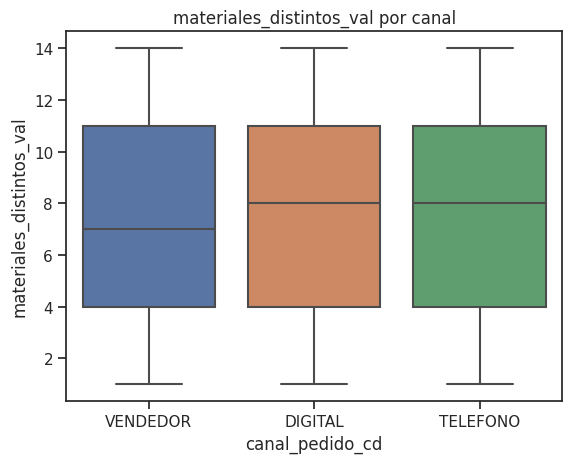

In [0]:
sns.boxplot(data=df_pedidos_clientes, x="canal_pedido_cd", y="materiales_distintos_val")
plt.title("materiales_distintos por canal")

Text(0.5, 1.0, 'cajas_fisicas por canal')

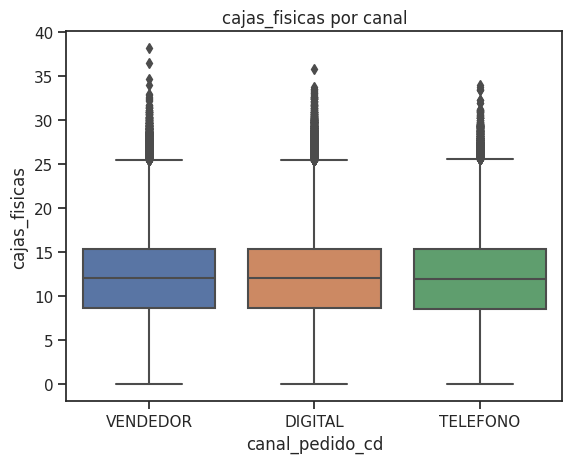

In [0]:
sns.boxplot(data=df_pedidos_clientes, x="canal_pedido_cd", y="cajas_fisicas")
plt.title("cajas_fisicas por canal")

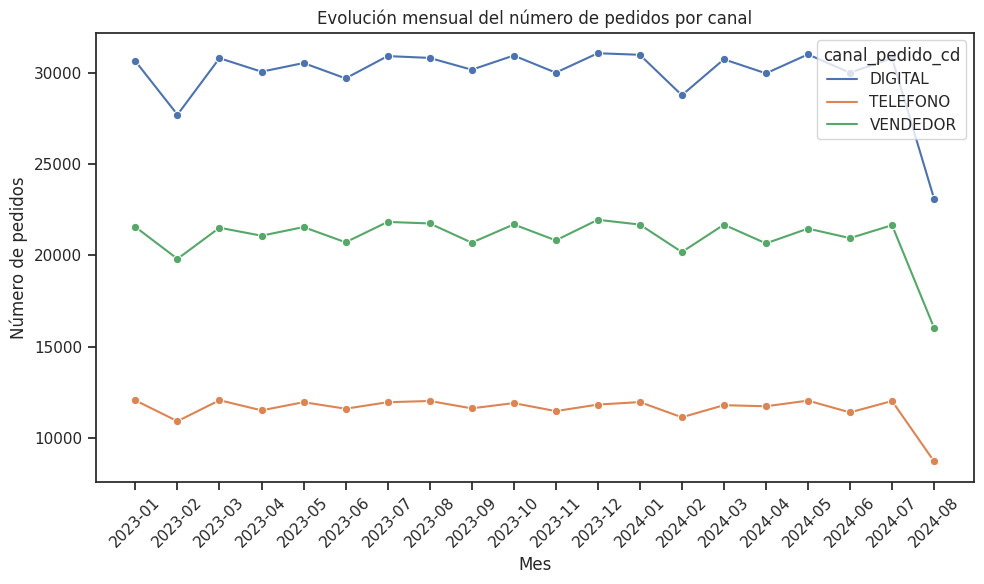

In [0]:
# Preparar datos
df = df_pedidos_clientes.copy()
df['mes_anio'] = df['fecha_pedido_dt'].dt.to_period('M').astype(str)

# Agrupar por mes y canal
canales_mensuales = df.groupby(['mes_anio', 'canal_pedido_cd']).size().reset_index(name='pedidos')

# Gráfico con Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=canales_mensuales, x='mes_anio', y='pedidos', hue='canal_pedido_cd', marker='o')

plt.title('Evolución mensual del número de pedidos por canal')
plt.ylabel('Número de pedidos')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Frecuencia de pedidos por canal (por cliente)')

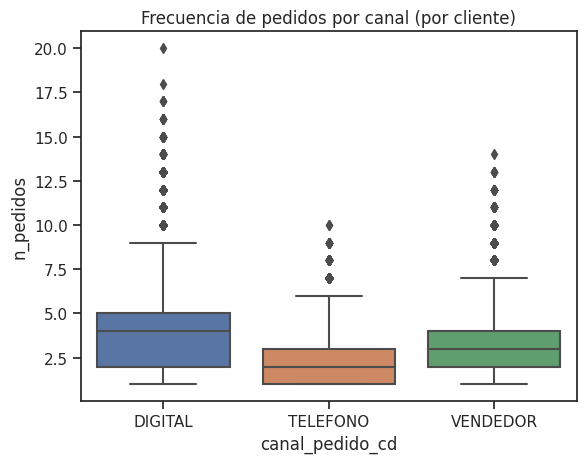

In [0]:
frecuencia = df.groupby(['cliente_id', 'canal_pedido_cd']).size().reset_index(name='n_pedidos')
sns.boxplot(data=frecuencia, x='canal_pedido_cd', y='n_pedidos')
plt.title("Frecuencia de pedidos por canal (por cliente)")


#### Analisis por Cliente

array([[<Axes: title={'center': 'pedidos por cliente'}>]], dtype=object)

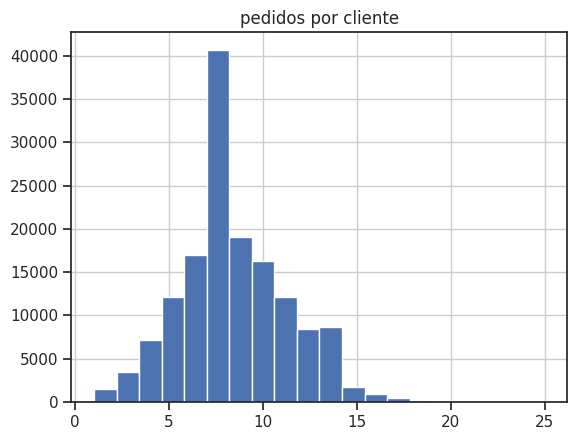

In [0]:
int_pedidos_clientes.groupBy("cliente_id").agg(F.count("*").alias("pedidos por cliente")).toPandas().hist(bins=20)

In [0]:
int_pedidos_clientes.groupBy("cliente_id").agg(F.count("*")).toPandas().describe()

,count(1)
count,149960.00000
mean,8.33556
std,2.88027
min,1.00000
25%,6.00000
50%,8.00000
75%,10.00000
max,25.00000


array([[<Axes: title={'center': 'canales_distintos_utilizados'}>]],
      dtype=object)

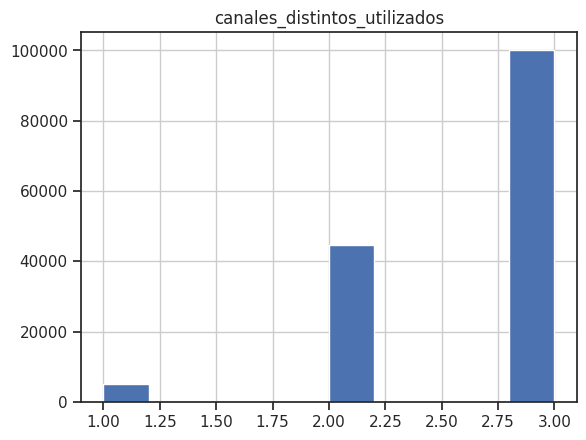

In [0]:
int_pedidos_clientes.groupBy("cliente_id").agg(F.countDistinct("canal_pedido_cd").alias("canales_distintos_utilizados")).toPandas().hist()

#### Analisis para Estructurar Target y MDT

In [0]:
# odena por cliente y fecha
w = Window.partitionBy("cliente_id").orderBy("fecha_pedido_dt")

# canal actual c canal siguiente
df_trans = tb_pedidos_clientes.withColumn("canal_actual", F.col("canal_pedido_cd"))
df_trans = df_trans.withColumn("canal_siguiente", F.lead("canal_pedido_cd").over(w))

# filtra donde hay un canal siguiente
df_trans = df_trans.filter(F.col("canal_siguiente").isNotNull())

# Tabla de transición
transitions = (df_trans.groupBy("canal_actual", "canal_siguiente")
                      .agg(F.count("*").alias("n"))
                      .toPandas()
                      .pivot(index="canal_actual", columns="canal_siguiente", values="n")
                      .fillna(0))

# proporcion por fila
transitions_prop = transitions.div(transitions.sum(axis=1), axis=0)


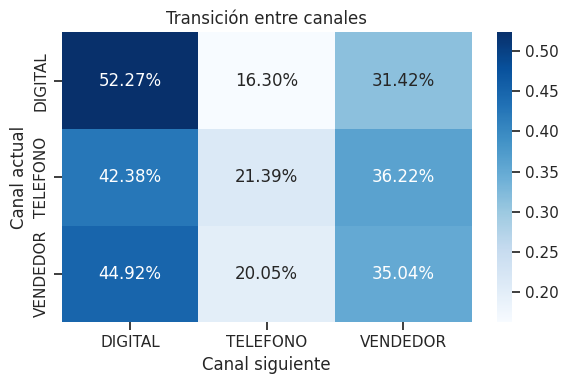

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(transitions_prop, annot=True, fmt=".2%", cmap="Blues")
plt.title("Transición entre canales")
plt.ylabel("Canal actual")
plt.xlabel("Canal siguiente")
plt.tight_layout()
plt.show()

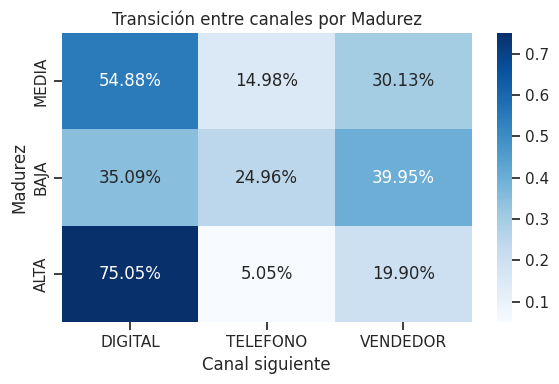

In [0]:
madurez_transition = (
    df_trans.groupBy("madurez_digital_cd", "canal_siguiente")
            .agg(F.count("*").alias("n"))
            .groupBy("madurez_digital_cd")
            .pivot("canal_siguiente")
            .sum("n")
            .fillna(0)
)

# Convertir a pandas y normalizar por fila
madurez_transition_pd = madurez_transition.toPandas().set_index("madurez_digital_cd")
madurez_transition_prop = madurez_transition_pd.div(madurez_transition_pd.sum(axis=1), axis=0)

def plot_transition_heatmap(df_prop, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_prop, annot=True, fmt=".2%", cmap="Blues")
    plt.title(title)
    plt.ylabel("Madurez")
    plt.xlabel("Canal siguiente")
    plt.tight_layout()
    plt.show()

# Ejemplo para madurez
plot_transition_heatmap(madurez_transition_prop, "Transición entre canales por Madurez")


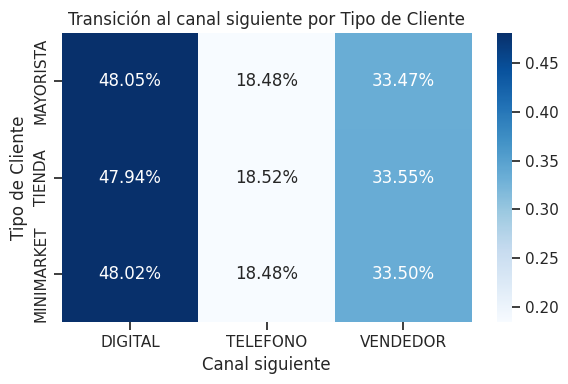

In [0]:
tipo_transition = (
    df_trans.groupBy("tipo_cliente_cd", "canal_siguiente")
            .agg(F.count("*").alias("n"))
            .groupBy("tipo_cliente_cd")
            .pivot("canal_siguiente")
            .sum("n")
            .fillna(0)
)

tipo_transition_pd = tipo_transition.toPandas().set_index("tipo_cliente_cd")
tipo_transition_prop = tipo_transition_pd.div(tipo_transition_pd.sum(axis=1), axis=0)

def plot_transition_heatmap(df_prop, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_prop, annot=True, fmt=".2%", cmap="Blues")
    plt.title(title)
    plt.ylabel("Tipo de Cliente")
    plt.xlabel("Canal siguiente")
    plt.tight_layout()
    plt.show()

plot_transition_heatmap(tipo_transition_prop, "Transición al canal siguiente por Tipo de Cliente")

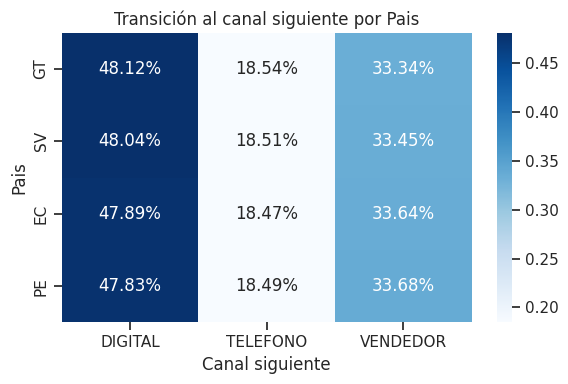

In [0]:
pais_transition = (
    df_trans.groupBy("pais_cd", "canal_siguiente")
            .agg(F.count("*").alias("n"))
            .groupBy("pais_cd")
            .pivot("canal_siguiente")
            .sum("n")
            .fillna(0)
)

pais_transition_pd = pais_transition.toPandas().set_index("pais_cd")
pais_transition_prop = pais_transition_pd.div(pais_transition_pd.sum(axis=1), axis=0)

def plot_transition_heatmap(df_prop, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_prop, annot=True, fmt=".2%", cmap="Blues")
    plt.title(title)
    plt.ylabel("Pais")
    plt.xlabel("Canal siguiente")
    plt.tight_layout()
    plt.show()

plot_transition_heatmap(pais_transition_prop, "Transición al canal siguiente por Pais")

<Axes: xlabel='estrellas_txt'>

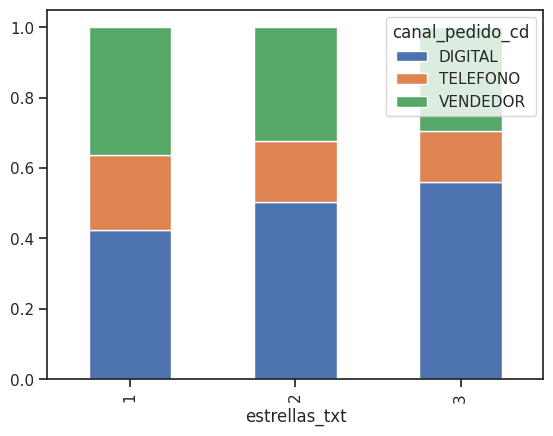

In [0]:
df.groupby("estrellas_txt")["canal_pedido_cd"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

<Axes: xlabel='frecuencia_visitas_cd', ylabel='count'>

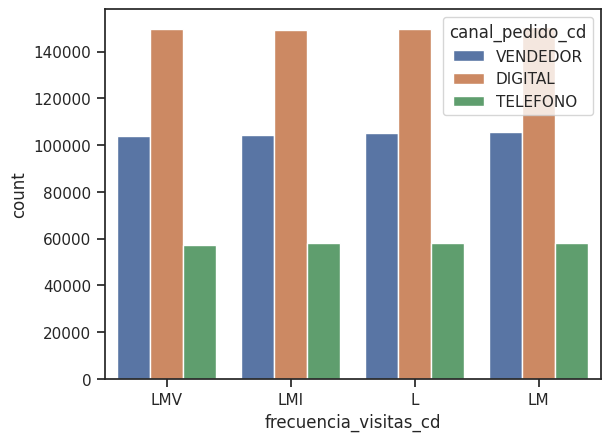

In [0]:
sns.countplot(data=df, x="frecuencia_visitas_cd", hue="canal_pedido_cd")

<Axes: title={'center': 'Distribución de target potencial'}, xlabel='target'>

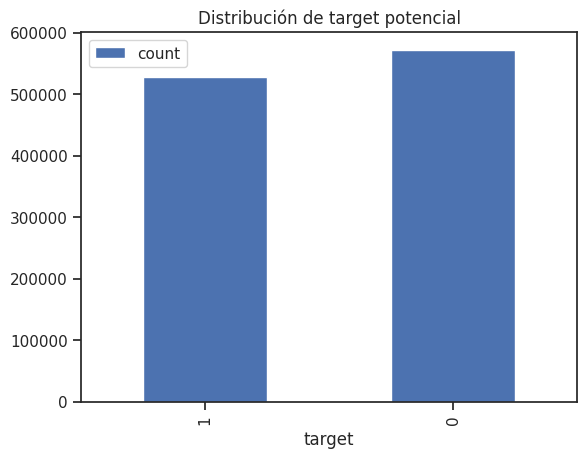

In [0]:
df_target = df_trans.withColumn("target", F.when(F.col("canal_siguiente") == "DIGITAL", 1).otherwise(0))
df_target.groupBy("target").count().toPandas().plot(kind="bar", x="target", y="count", title="Distribución de target potencial")